## IF curve example
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/if_curve.html

In [1]:
import shelve

import nest
import numpy

[admin:1815013] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.admin.1000/jf.0/2888761344/shared_mem_cuda_pool.admin could be created.
[admin:1815013] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Oct  2 2024 11:54:50

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
model = "aeif_cond_exp"
params = {
    "a": 4.0,
    "b": 80.8,
    "V_th": -50.4,
    "Delta_T": 2.0,
    "I_e": 0.0,
    "C_m": 281.0,
    "g_L": 30.0,
    "V_reset": -70.6,
    "tau_w": 144.0,
    "t_ref": 5.0,
    "V_peak": -40.0,
    "E_L": -70.6,
    "E_ex": 0.0,
    "E_in": -70.0,
}


class IF_curve:
    t_inter_trial = 200.0  # Interval between two successive measurement trials
    t_sim = 1000.0  # Duration of a measurement trial
    n_neurons = 100  # Number of neurons
    n_threads = 4  # Nubmer of threads to run the simulation

    def __init__(self, model, params=None):
        self.model = model
        self.params = params
        self.build()
        self.connect()

    def build(self):
        #######################################################################
        #  We reset NEST to delete information from previous simulations
        # and adjust the number of threads.

        nest.ResetKernel()
        nest.local_num_threads = self.n_threads

        #######################################################################
        # We create neurons and devices with specified parameters.

        self.neuron = nest.Create(self.model, self.n_neurons, self.params)
        self.noise = nest.Create("noise_generator")
        self.spike_recorder = nest.Create("spike_recorder")

    def connect(self):
        #######################################################################
        # We connect the noisy current to the neurons and the neurons to
        # the spike recorders.

        nest.Connect(self.noise, self.neuron, "all_to_all")
        nest.Connect(self.neuron, self.spike_recorder, "all_to_all")

    def output_rate(self, mean, std):
        self.build()
        self.connect()

        #######################################################################
        # We adjust the parameters of the noise according to the current
        # values.

        self.noise.set(mean=mean, std=std, start=0.0, stop=1000.0, origin=0.0)

        # We simulate the network and calculate the rate.

        nest.Simulate(self.t_sim)
        rate = self.spike_recorder.n_events * 1000.0 / (1.0 * self.n_neurons * self.t_sim)
        return rate

    def compute_transfer(self, i_mean=(400.0, 900.0, 50.0), i_std=(0.0, 600.0, 50.0)):
        #######################################################################
        # We loop through all possible combinations of `(I_mean, I_sigma)`
        # and measure the output rate of the neuron.

        self.i_range = numpy.arange(*i_mean)
        self.std_range = numpy.arange(*i_std)
        self.rate = numpy.zeros((self.i_range.size, self.std_range.size))
        nest.set_verbosity("M_WARNING")
        for n, i in enumerate(self.i_range):
            print("I  =  {0}".format(i))
            for m, std in enumerate(self.std_range):
                self.rate[n, m] = self.output_rate(i, std)


transfer = IF_curve(model, params)
transfer.compute_transfer()

I  =  400.0
I  =  450.0
I  =  500.0
I  =  550.0
I  =  600.0
I  =  650.0
I  =  700.0
I  =  750.0
I  =  800.0
I  =  850.0


In [5]:
with shelve.open("data/" + model + "_transfer") as dat:
    dat["I_mean"] = transfer.i_range
    dat["I_std"] = transfer.std_range
    dat["rate"] = transfer.rate

In [7]:
transfer.i_range

array([400., 450., 500., 550., 600., 650., 700., 750., 800., 850.])

In [8]:
transfer.std_range

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550.])

In [12]:
rate = transfer.rate

In [13]:
rate.shape

(10, 12)

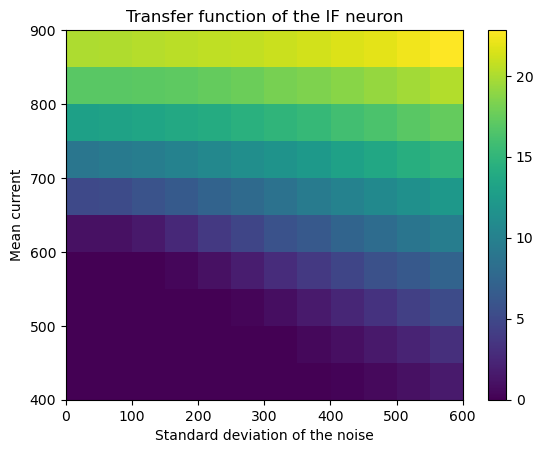

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(transfer.rate, aspect="auto", origin="lower", extent=[0, 600, 400, 900])
plt.colorbar()
plt.xlabel("Standard deviation of the noise")
plt.ylabel("Mean current")
plt.title("Transfer function of the IF neuron")
plt.show()
